### DEMAND FORECASTING PIPELINE

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time


#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

/home/choclo/anaconda3/envs/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

### READING IN DATA
Sales dataset from kaggle from Favorita stores in Ecuador. (ref: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv)

In [7]:
df = pd.read_csv('store_data.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'], format= "%Y-%m-%d")

In [8]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [9]:
df.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE   0.00            0
1   1 2013-01-01          1   BABY CARE   0.00            0
2   2 2013-01-01          1      BEAUTY   0.00            0
3   3 2013-01-01          1   BEVERAGES   0.00            0
4   4 2013-01-01          1       BOOKS   0.00            0

Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. The line of code below can also be done in SQL.
<i>select date,
        family, 
        sum(sales)
from df
group by date, family
</i>

In [10]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [11]:
agg_df.head()

date      family  sales
0   2013-01-01  AUTOMOTIVE   0.00
33  2013-01-02  AUTOMOTIVE 255.00
66  2013-01-03  AUTOMOTIVE 161.00
99  2013-01-04  AUTOMOTIVE 169.00
132 2013-01-05  AUTOMOTIVE 342.00

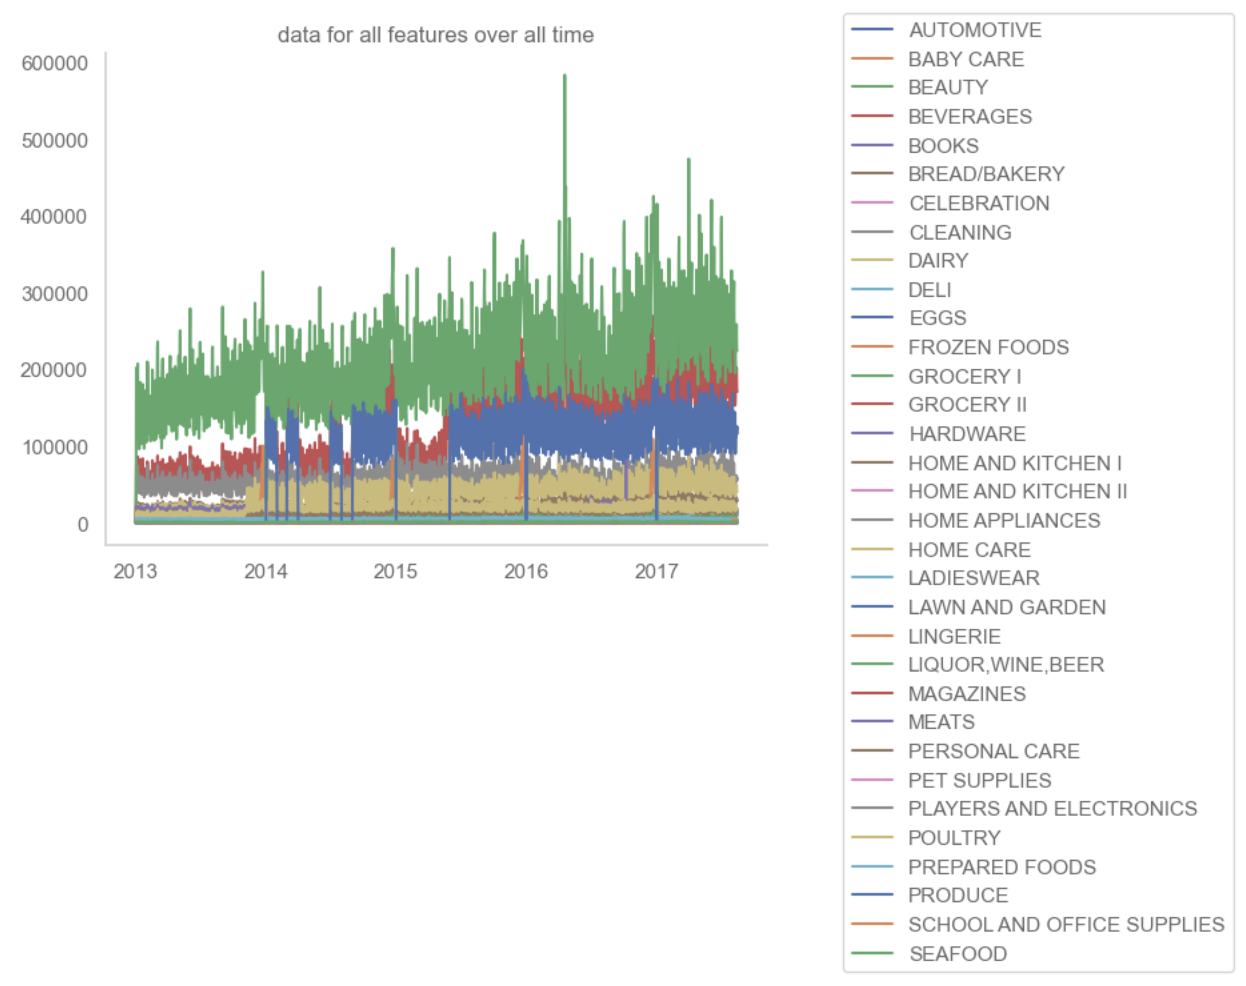

In [12]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.drop('LIQUOR,WINE,BEER',axis='columns',inplace=True)
total_sales_df.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01        0.00       0.00    2.00     810.00   0.00        180.59   
2013-01-02      255.00       0.00  207.00   72092.00   0.00      26246.32   
2013-01-03      161.00       0.00  125.00   52105.00   0.00      18456.48   
2013-01-04      169.00       0.00  133.00   54167.00   0.00      16721.97   
2013-01-05      342.00       0.00  191.00   77818.00   0.00      22367.76   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2013-01-01         0.00    186.00   143.00    71.09    46.00         29.65   
2013-01-02         0.00  74629.00 23381.00 15754.50 10932.00       7115.39   
2013-01-03         0.00  55893.00 18001.00 11172.45  7358.00       4760.81   
2013-01-04         0.00  52064.00 18148.00 10143.21  6760.00       4525.93   
2013-01-05         0.00  70128.00 23082.00 13734.95  8576.00       5781.61   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2013-01-01     700.00       15.00      0.00                0.00   
2013-01-02  202020.00     1476.00     46.00                0.00   
2013-01-03  144878.00     1048.00     37.00                0.00   
2013-01-04  135754.00     1031.00     57.00                0.00   
2013-01-05  188356.00     1273.00     87.00                0.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2013-01-01                 0.00             0.00       0.00        0.00   
2013-01-02                 0.00            21.00       0.00        0.00   
2013-01-03                 0.00            15.00       0.00        0.00   
2013-01-04                 0.00            13.00       0.00        0.00   
2013-01-05                 0.00            11.00       0.00        0.00   

family      LAWN AND GARDEN  LINGERIE  MAGAZINES    MEATS  PERSONAL CARE  \
date                                                                       
2013-01-01             2.00      5.00       0.00   110.80          25.00   
2013-01-02           121.00    469.00       0.00 20871.46       17204.00   
2013-01-03            83.00    366.00       0.00 16597.40       12568.00   
2013-01-04           127.00    382.00       0.00 21625.96       11303.00   
2013-01-05           180.00    458.00       0.00 20879.09       16819.00   

family      PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  PREPARED FOODS  \
date                                                                         
2013-01-01          0.00                     0.00    42.64           37.85   
2013-01-02          0.00                     0.00 13975.88         5338.11   
2013-01-03          0.00                     0.00 10674.39         3591.39   
2013-01-04          0.00                     0.00 10772.52         4472.97   
2013-01-05          0.00                     0.00 13475.01         5830.07   

family      PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                      
2013-01-01     0.00                        0.00     0.00  
2013-01-02     0.00                        0.00  1526.75  
2013-01-03     0.00                        0.00  1094.31  
2013-01-04     0.00                        0.00  1293.12  
2013-01-05     0.00                        0.00  1245.64

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

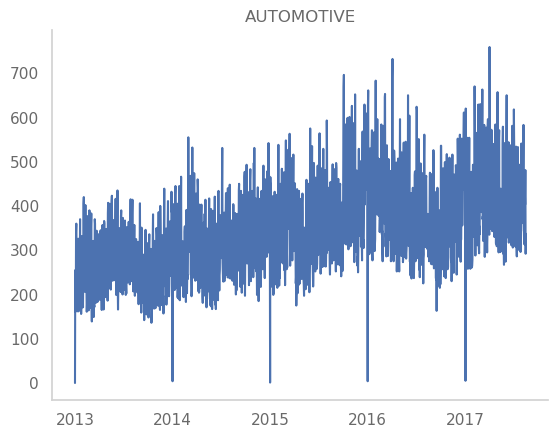

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

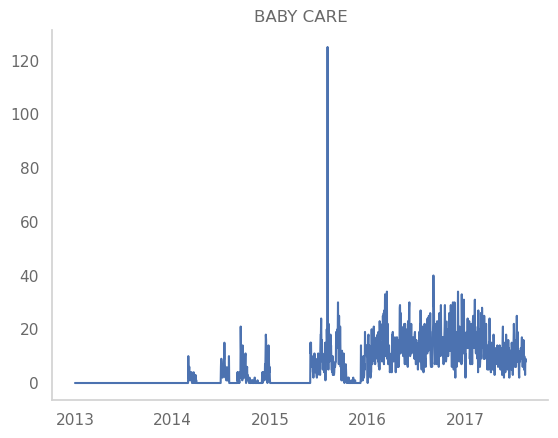

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

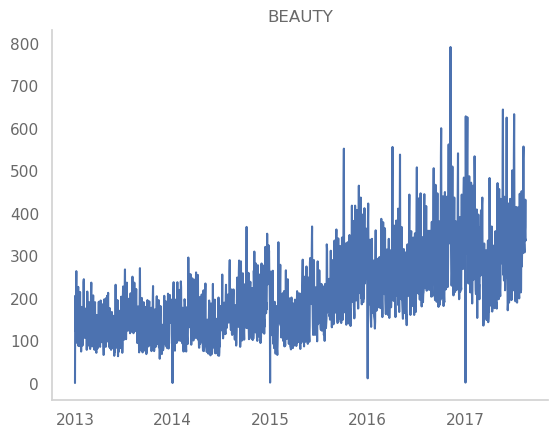

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

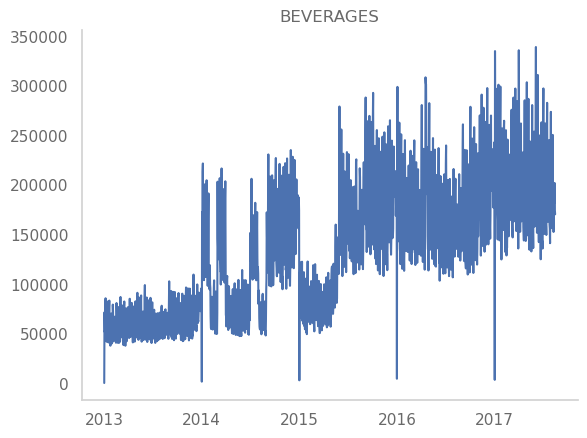

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

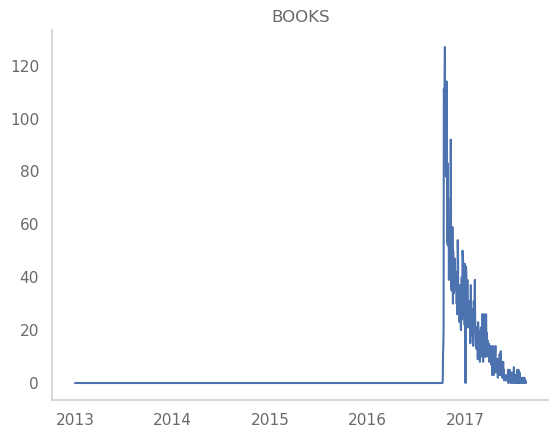

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

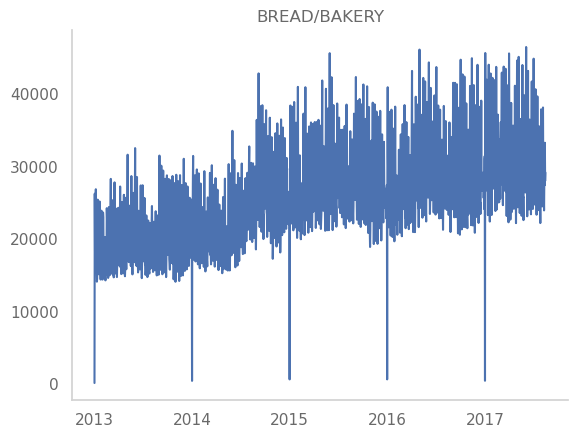

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

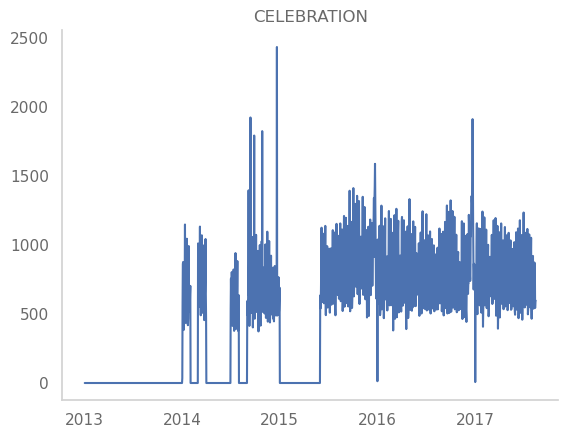

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

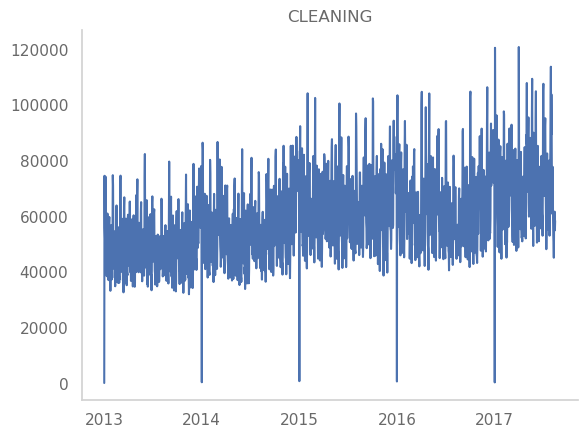

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

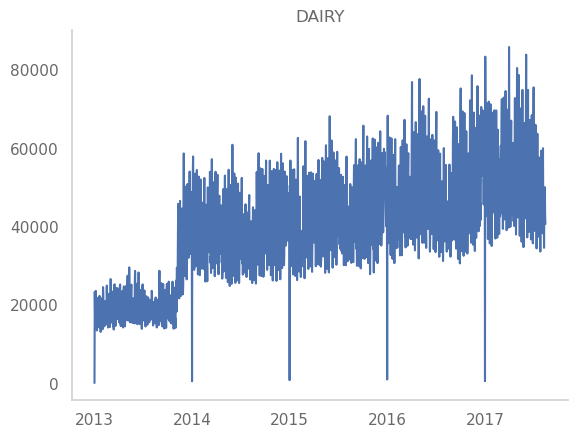

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

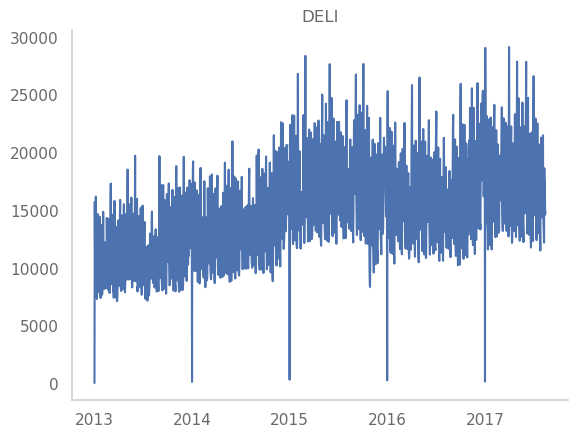

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

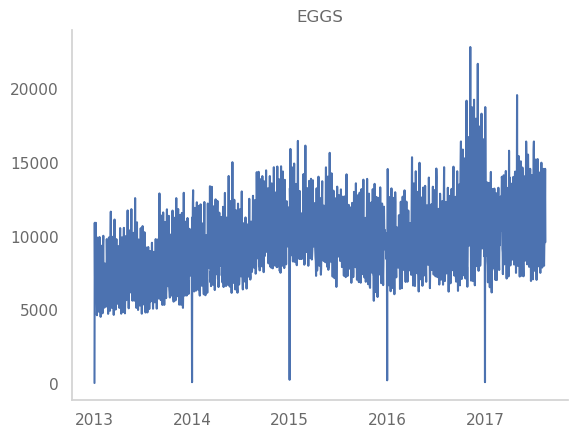

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

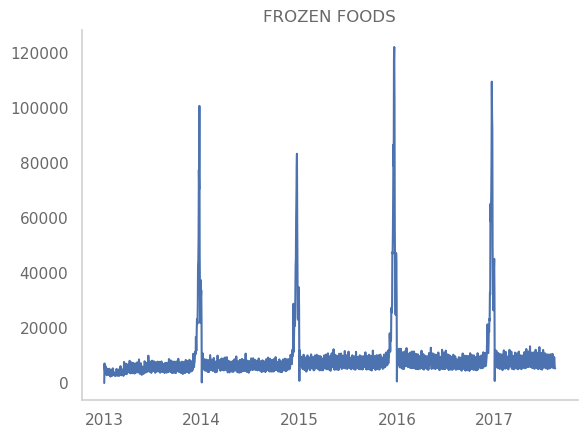

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

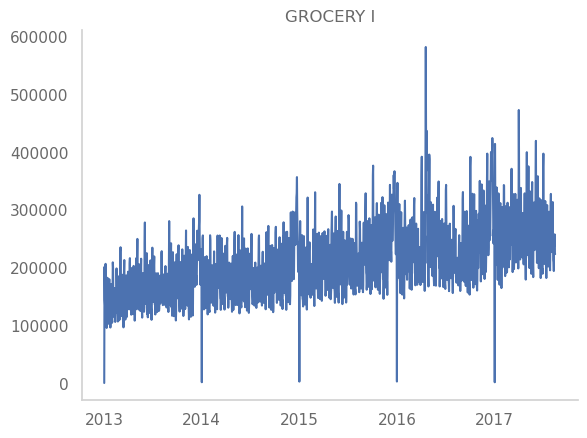

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

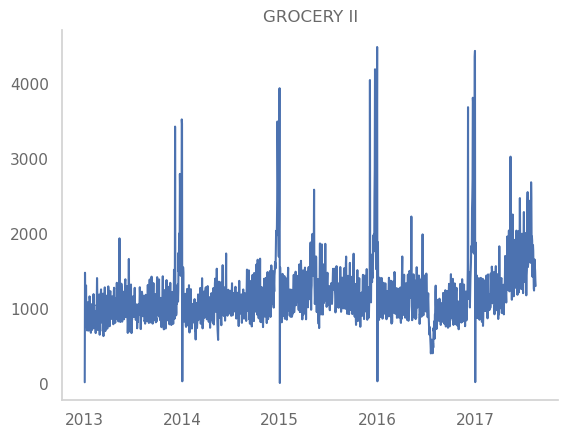

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

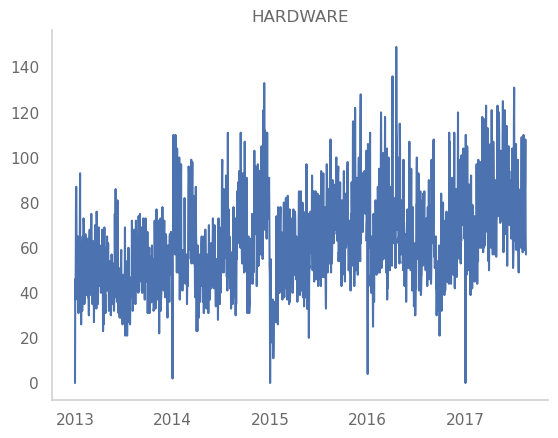

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

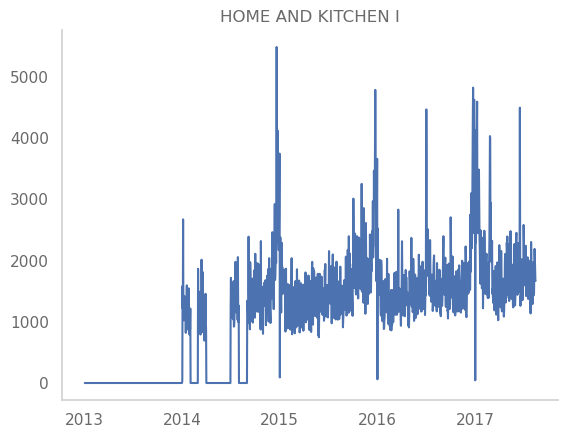

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

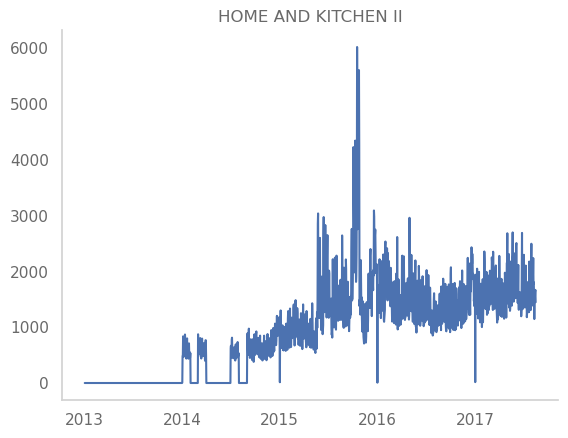

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

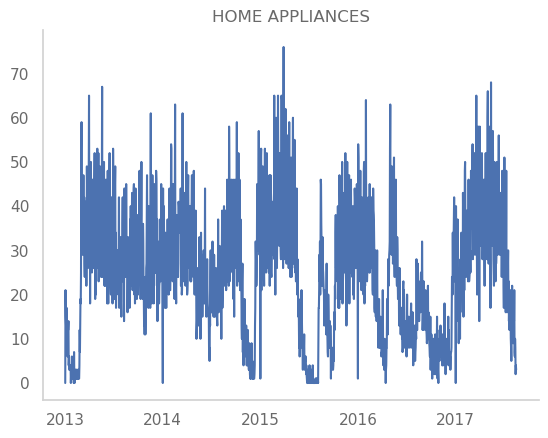

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

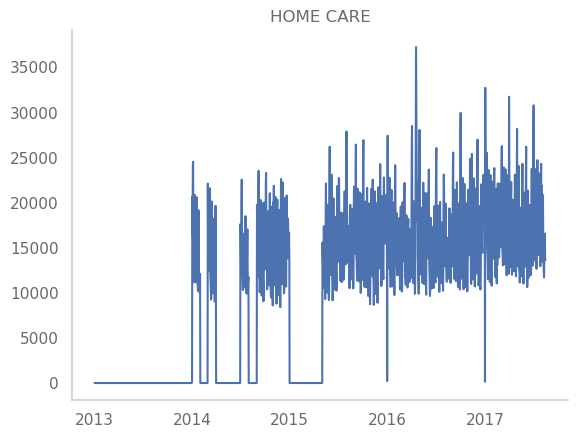

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

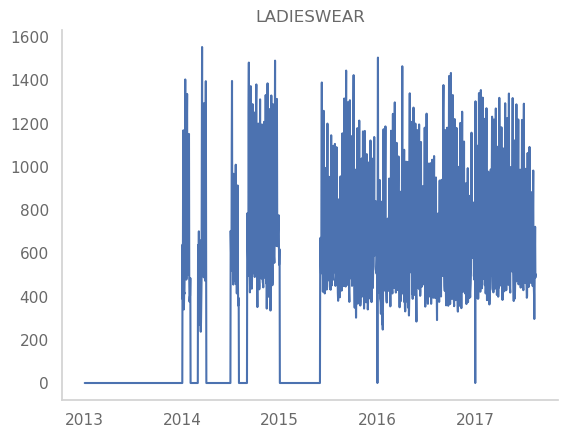

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

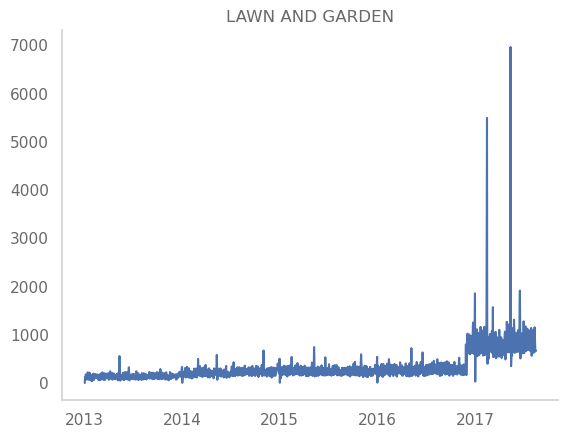

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

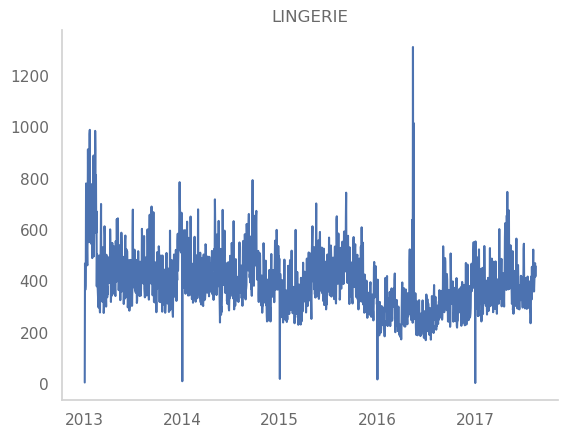

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

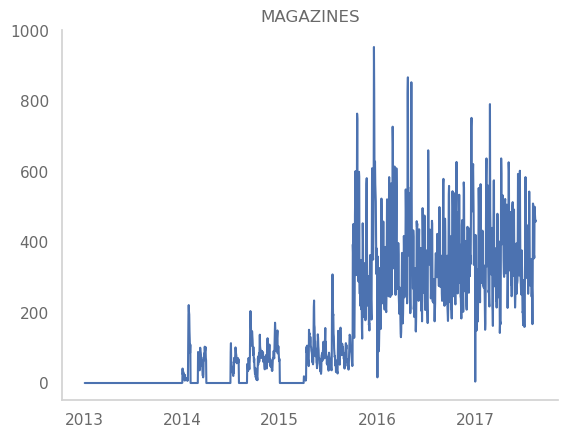

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

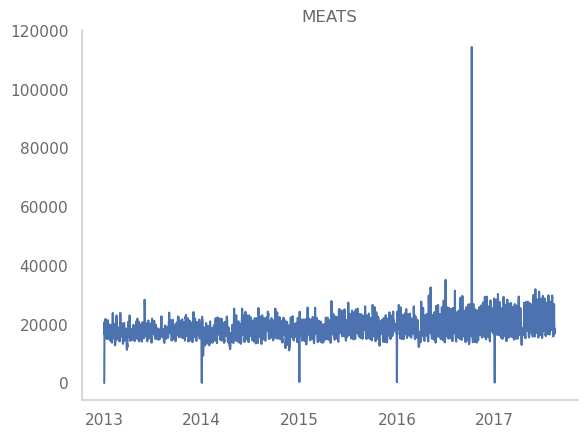

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

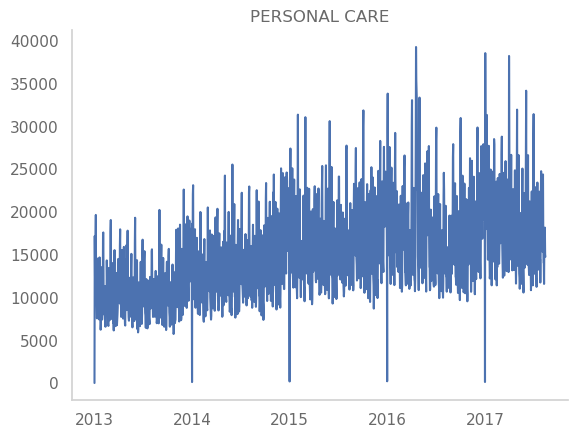

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

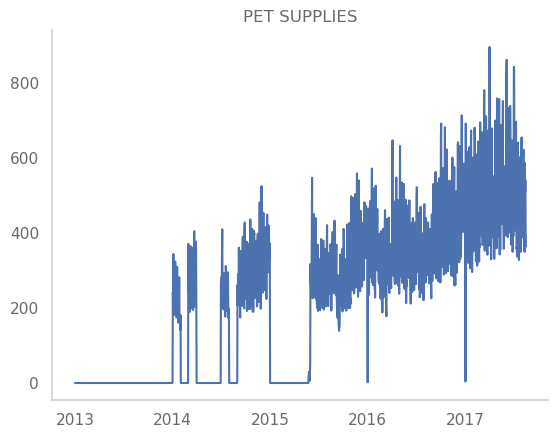

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

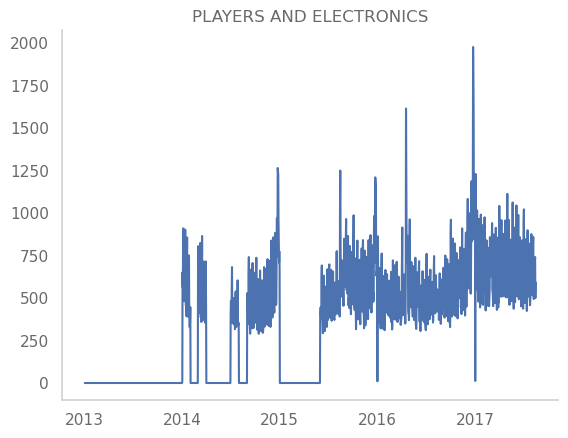

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

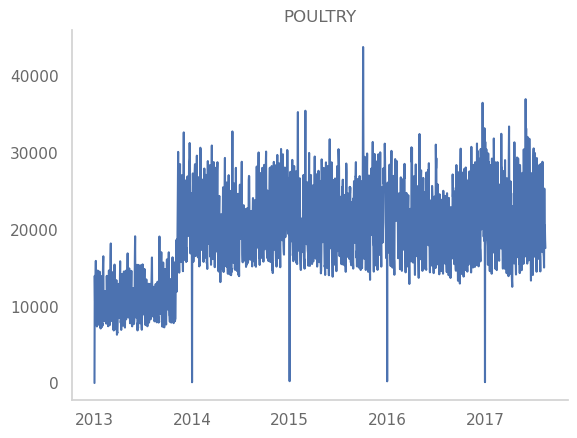

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

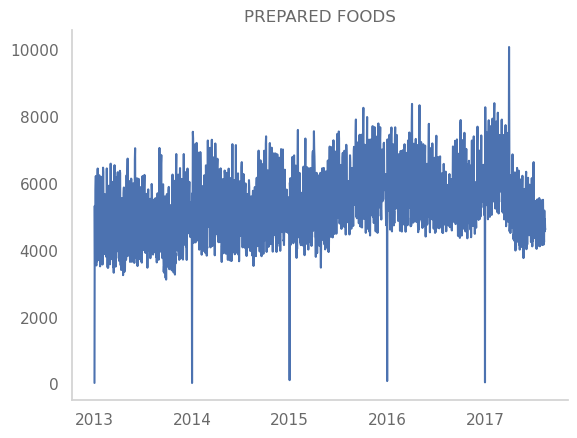

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

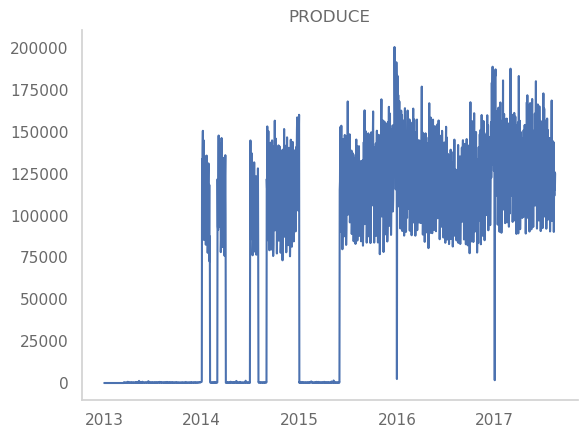

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

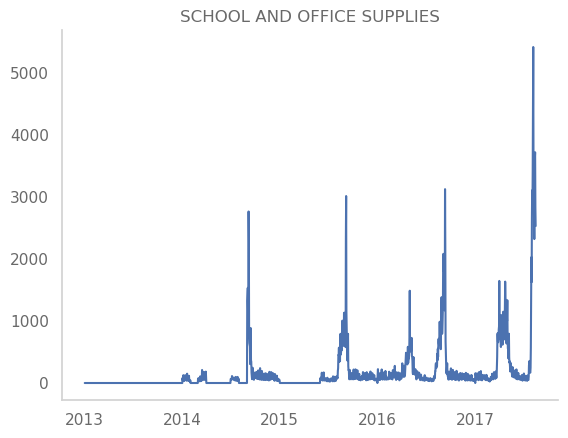

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

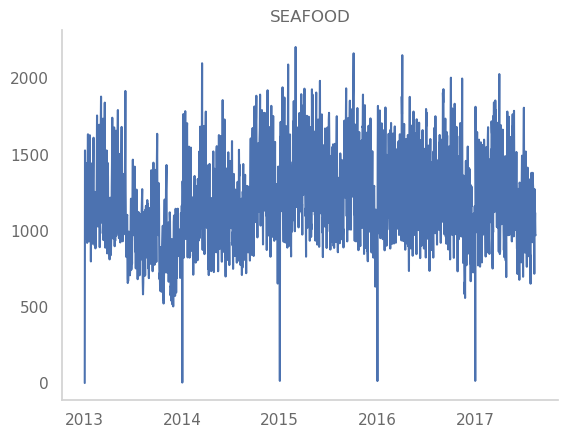

In [13]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

In [14]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

In [15]:
missing_data(total_sales_df).head()

Total  Percent    Types
family                             
AUTOMOTIVE      0     0.00  float64
BABY CARE       0     0.00  float64
BEAUTY          0     0.00  float64
BEVERAGES       0     0.00  float64
BOOKS           0     0.00  float64

### DATA CLEANING REQUIREMENTS
1. Remove low-volume data that can't be predicted.
2. Remove situations where there's not enough data. (i.e. by visual inspection or by number of '0' daily sales counts.
3. Remove outliers (automated by calculating z-score and just removing it and having Prophet impute those values). This will remove the outliers near 0 for all categories.
4. Check if more data needs to be removed after filtering to 08/15/15 - 08/15/17. If not, then we can move throughout the pipeline.

In [16]:
old_len = len(total_sales_df.columns)

#Keep categories with avg daily sales greater than $1000
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') > 1000]]

print("Dropping "+ str(old_len-len(total_sales_df.columns))+" columns due to insufficient data volume.")

Dropping 14 columns due to insufficient data volume.


In [17]:
#Get percentage of rows for each category that is at 0

(total_sales_df == 0).astype(int).sum(axis=0)/len(total_sales_df.sum(axis=0))

family
BEVERAGES             0.00
BREAD/BAKERY          0.00
CLEANING              0.00
DAIRY                 0.00
DELI                  0.00
EGGS                  0.00
FROZEN FOODS          0.00
GROCERY I             0.00
GROCERY II            0.00
HOME AND KITCHEN I    0.00
HOME AND KITCHEN II   0.00
HOME CARE             0.00
MEATS                 0.00
PERSONAL CARE         0.00
POULTRY               0.00
PREPARED FOODS        0.00
PRODUCE               0.00
SEAFOOD               0.00
dtype: float64

After checking for 0s and not seeing any issues, we can keep all the categories that we have left in the dataframe.

In [18]:
print(total_sales_df.columns)

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')


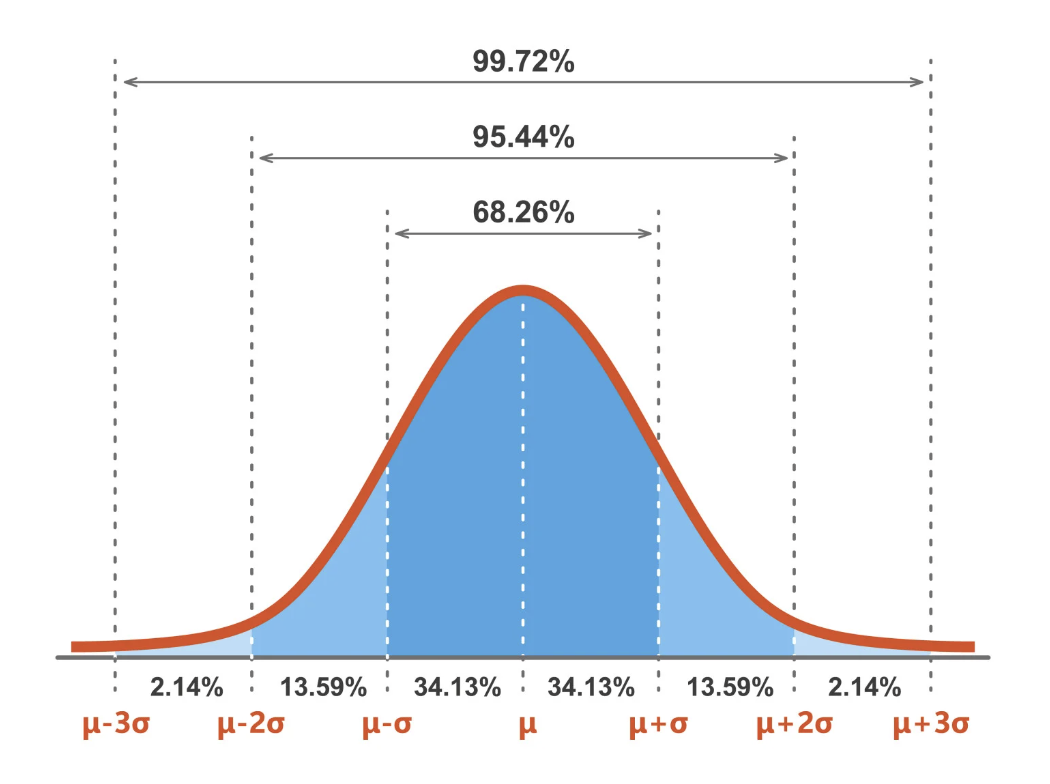

In [19]:
#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)

Dropping 7 rows for following category: BEVERAGES
Dropping 11 rows for following category: BREAD/BAKERY
Dropping 10 rows for following category: CLEANING
Dropping 10 rows for following category: DAIRY
Dropping 9 rows for following category: DELI
Dropping 12 rows for following category: EGGS
Dropping 22 rows for following category: FROZEN FOODS
Dropping 11 rows for following category: GROCERY I
Dropping 15 rows for following category: GROCERY II
Dropping 23 rows for following category: HOME AND KITCHEN I
Dropping 15 rows for following category: HOME AND KITCHEN II
Dropping 13 rows for following category: HOME CARE
Dropping 4 rows for following category: MEATS
Dropping 14 rows for following category: PERSONAL CARE
Dropping 5 rows for following category: POULTRY
Dropping 3 rows for following category: PREPARED FOODS
Dropping 4 rows for following category: PRODUCE
Dropping 4 rows for following category: SEAFOOD


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

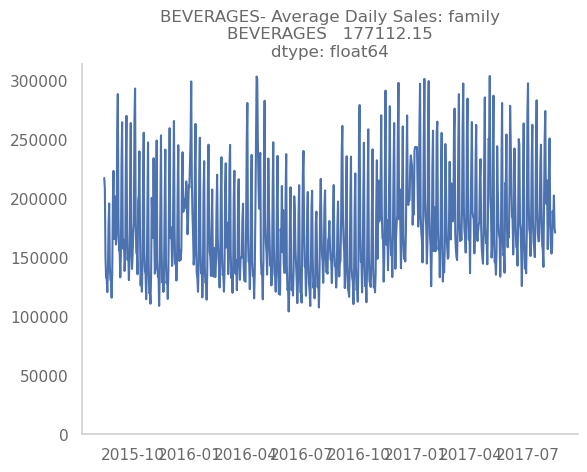

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

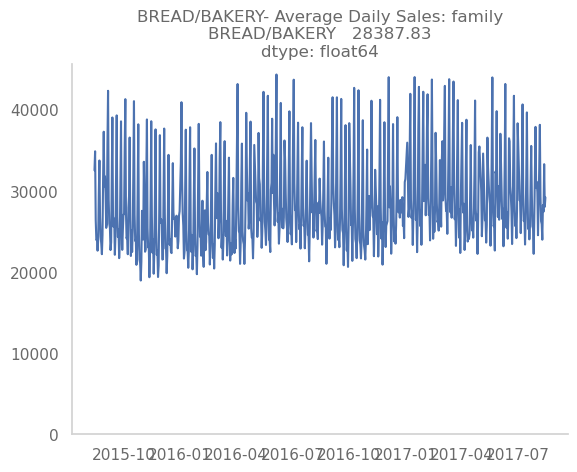

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

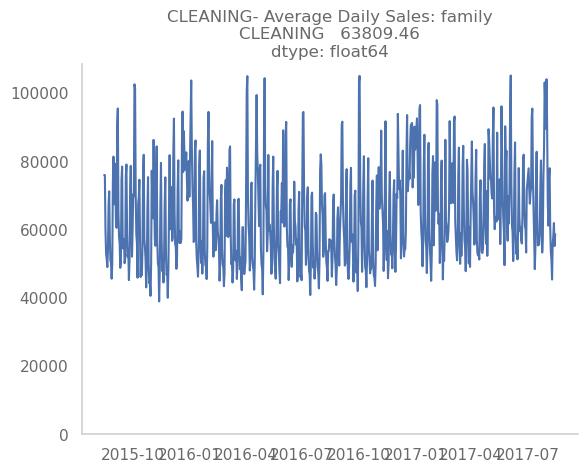

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

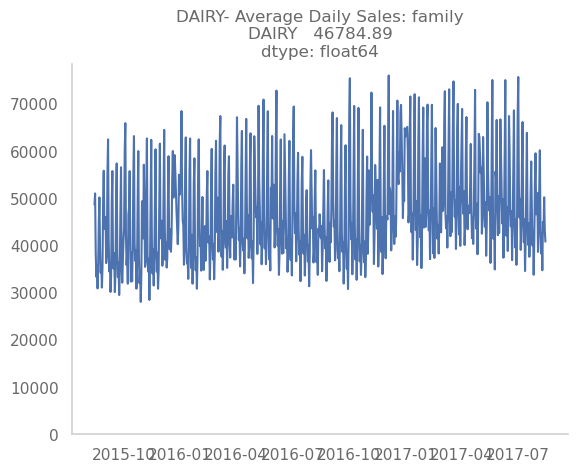

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

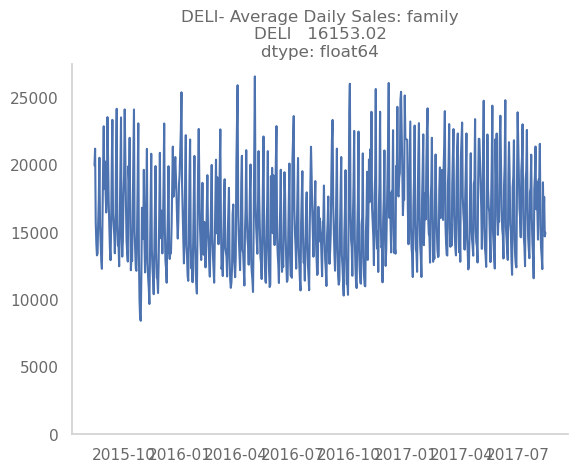

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

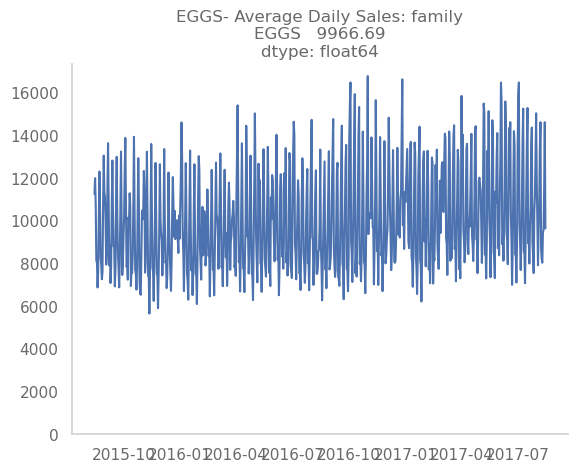

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

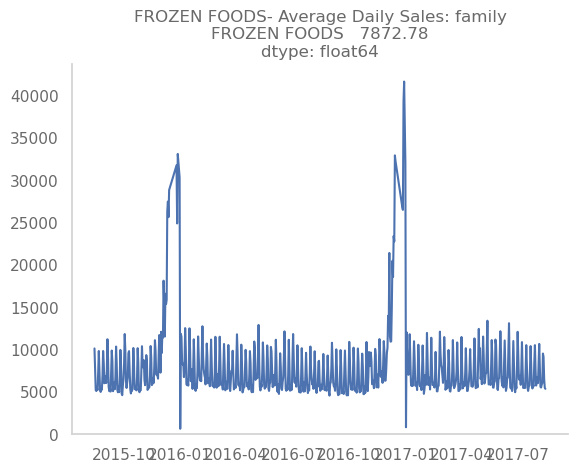

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

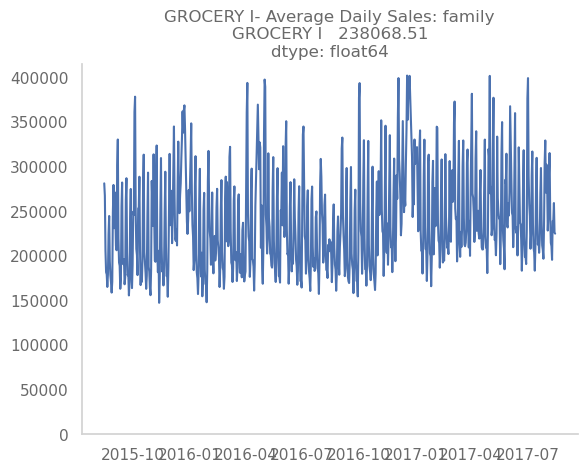

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

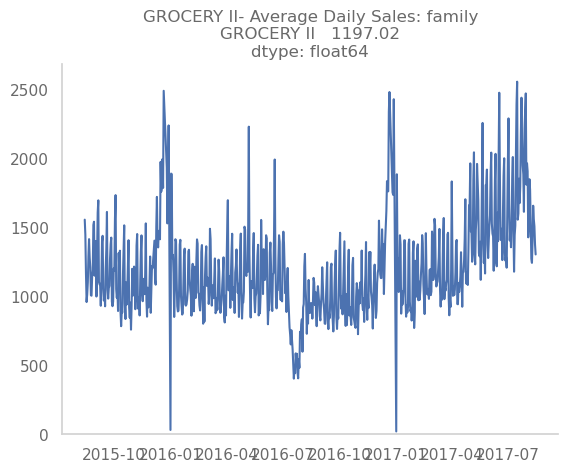

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

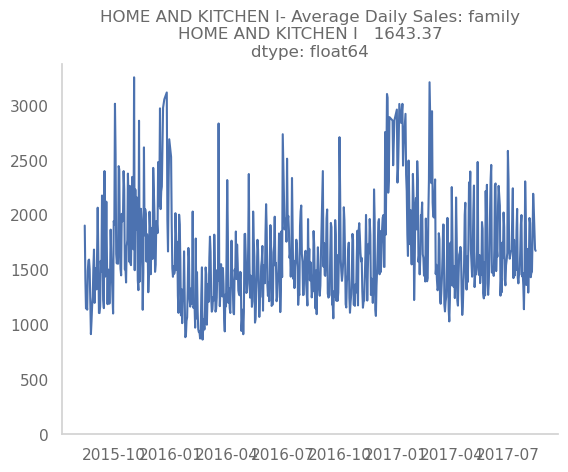

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

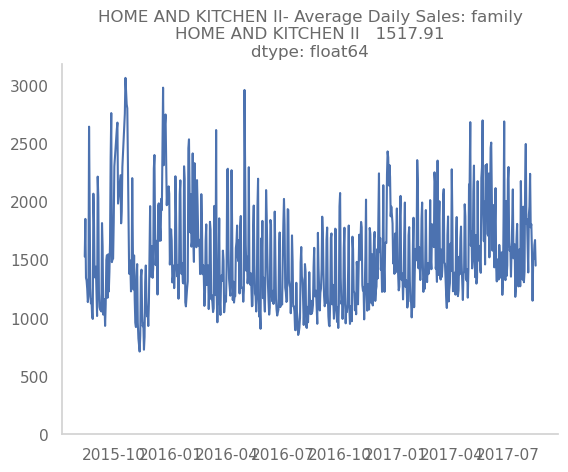

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

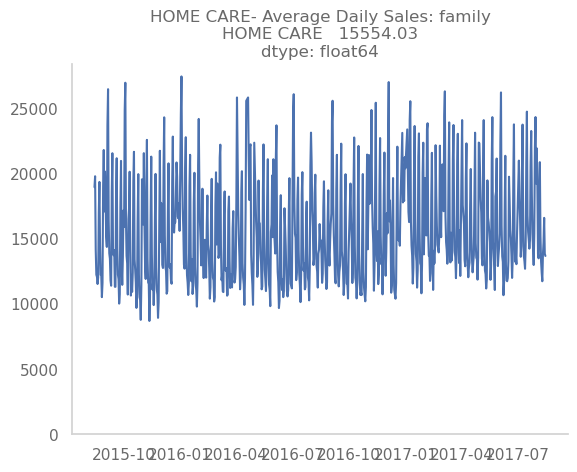

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

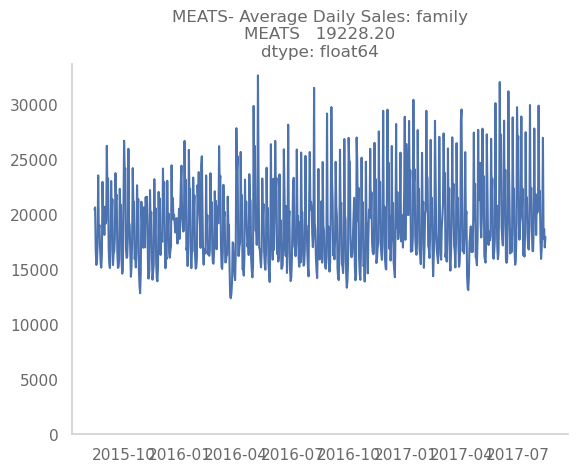

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

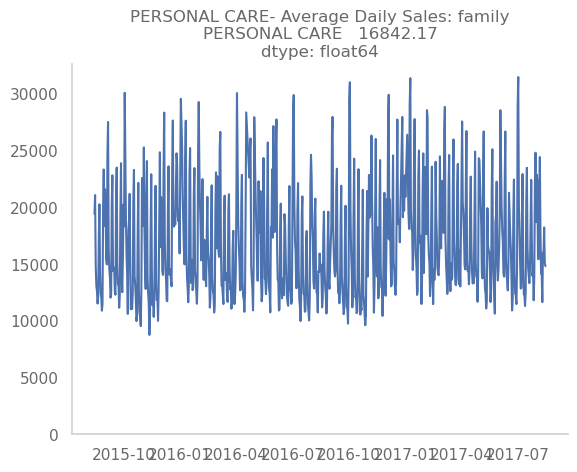

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

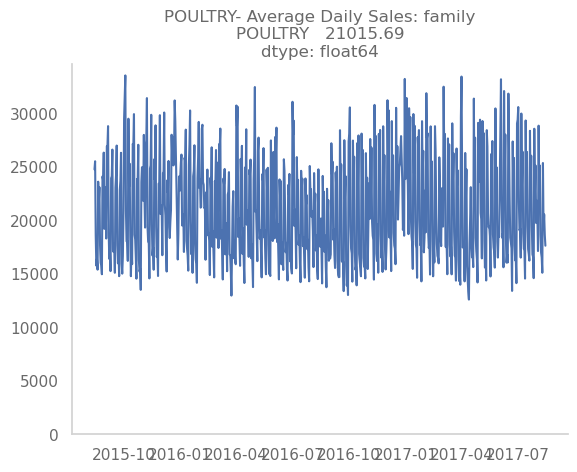

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

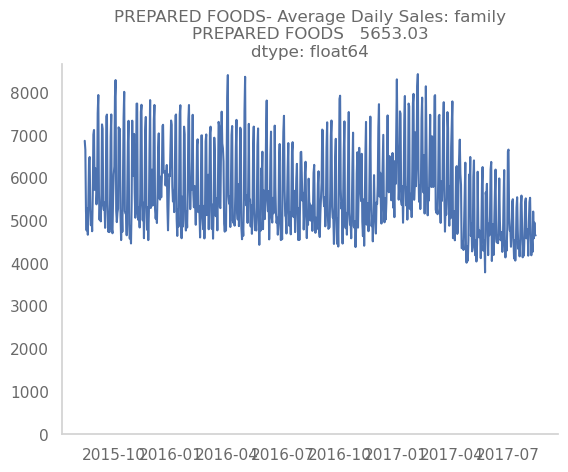

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

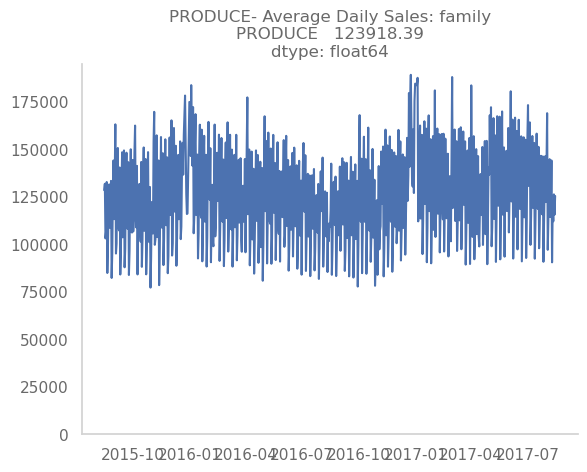

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

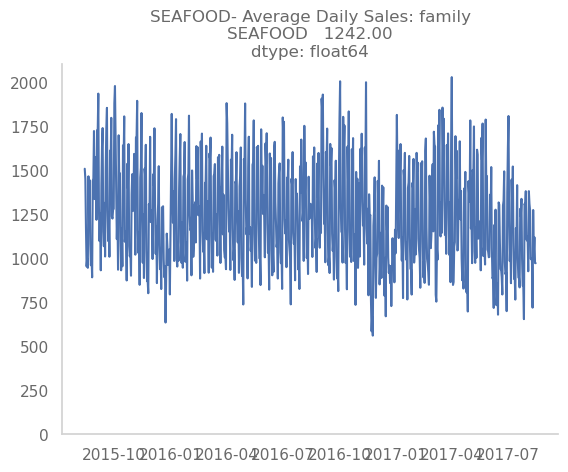

In [20]:
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(prediction_df_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

For further hypertuning, things to adjust would be on the category level. I'm not going to do further hypertuning in this notebook but here are the following things you can test and adjust to determine whether it's a category that can be predicted given the data.

1. Impute or drop situations for the <b>Liquor, Beer, Wine category</b> since there are many 0s in the first years worth of data. See if it improves the MAPE after cross-validation.
2. Impute or drop situations for the <b>Grocery II and Frozen Food categories </b> since there are 0s near the January 1st beginning of the year timeline that didn't get dropped during the z-score outlier automation. See if it improves the MAPE after cross-validation.
3. <b>Adjust the z-score outlier parameter</b> by checking out the Gaussian Distribution for different z-scores, check cut-offs and counts of rows being dropped, and see if there's an ideal situation for getting the best MAPE. (Idea is to loop through possible z-score possibilies, perhaps between 5 linear possibilities between 2.5 --> 3 and run the models with the best hypertuned parameters based on cross-validation below to see if MAPE's change with a change in z-score outlier drops.

### PLOTTING CATEGORIES

In [21]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [22]:
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index.tolist()
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

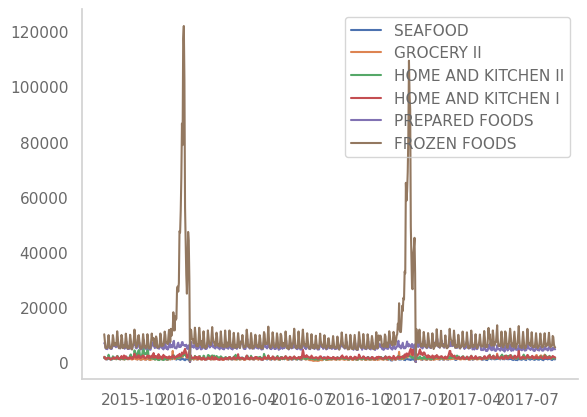

In [23]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

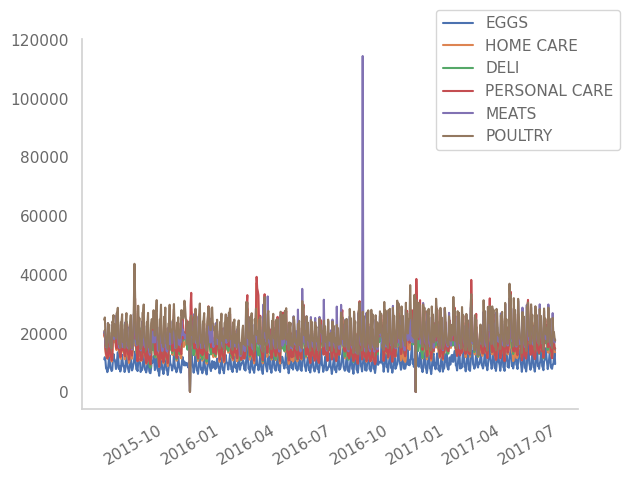

In [24]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

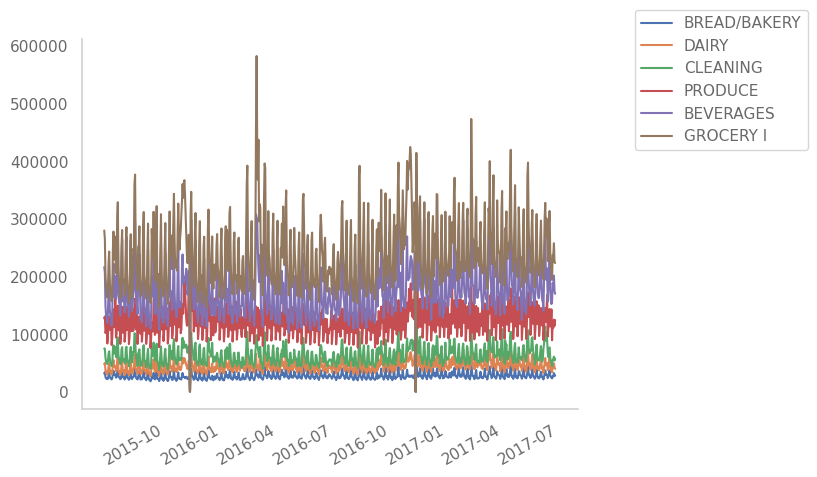

In [25]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

### HYPERPARAMETER TUNING AND BACKTESTING PIPELINE

Ranges give on Prophet's documentation

1. changepoint_prior_scale [0.001, 0.5] 
2. seasonality_prior_scale [0.01, 10]
3. holidays_prior_scale [0.01, 10] 
4. seasonality_mode ['additive', 'multiplicative'].
5. changepoint_range [0.5, 0.95]

https://facebook.github.io/prophet/docs/diagnostics.html

In [26]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [27]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

#seasonality_mode_options = ['additive', 'multiplicative']
#changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

In [ ]:
start_time = time.time()

dicts = {}

for feature in total_sales_df.columns:
  
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time)) #about 18 minutes

12:14:54 - cmdstanpy - INFO - Chain [1] start processing
12:14:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]12:14:54 - cmdstanpy - INFO - Chain [1] start processing
12:14:54 - cmdstanpy - INFO - Chain [1] done processing
12:14:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:14:54 - cmdstanpy - INFO - Chain [1] start processing
12:14:54 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:05,  2.13it/s]12:14:54 - cmdstanpy - INFO - Chain [1] start processing
12:14:54 - cmdstanpy - INFO - Chain [1] done processing
12:14:55 - cmdstanpy - INFO - Chain [1] start processing
12:14:55 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.70it/s]12:14:55 - cmdstanpy - INFO - Chain [1] start

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2026984248.58 45022.04 34005.50  0.33   0.15   0.20      0.64


  0%|          | 0/12 [00:00<?, ?it/s]12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:09,  1.21it/s]12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:59 - cmdstanpy - INFO - Chain [1] start processing
12:14:59 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.76it/s]12:14:59 - cmdstanpy - INFO - Chain [1] start processing
12:14:59 - cmdstanpy - INFO - Chain [1] done processing
12:14:59 - cmdstanpy - INFO - Chain [1] start processing
12:14:59 - cmdstanpy - INFO - Chain [1] done processing
12:14:59 - cmdstanpy - ERROR - Chain

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2161021657.18 46486.79 36388.80  0.37   0.17   0.22      0.55


  0%|          | 0/12 [00:00<?, ?it/s]12:15:02 - cmdstanpy - INFO - Chain [1] start processing
12:15:02 - cmdstanpy - INFO - Chain [1] done processing
12:15:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:15:02 - cmdstanpy - INFO - Chain [1] start processing
12:15:03 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:10,  1.08it/s]12:15:03 - cmdstanpy - INFO - Chain [1] start processing
12:15:03 - cmdstanpy - INFO - Chain [1] done processing
12:15:03 - cmdstanpy - INFO - Chain [1] start processing
12:15:03 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:02,  3.34it/s]12:15:03 - cmdstanpy - INFO - Chain [1] start processing
12:15:03 - cmdstanpy - INFO - Chain [1] done processing
12:15:03 - cmdstanpy - INFO - Chain [1] start processing
12:15:03 - cmdstanpy - INFO - Chain [1] done processing
12:15:03 - cmdstanpy - ERROR - Chain

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2167321869.56 46554.50 36442.50  0.37   0.17   0.22      0.56


  0%|          | 0/12 [00:00<?, ?it/s]12:15:05 - cmdstanpy - INFO - Chain [1] start processing
12:15:05 - cmdstanpy - INFO - Chain [1] done processing
12:15:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:15:05 - cmdstanpy - INFO - Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:07,  1.42it/s]12:15:06 - cmdstanpy - INFO - Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing
12:15:06 - cmdstanpy - INFO - Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.15it/s]12:15:06 - cmdstanpy - INFO - Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.10it/s]12:15:06 - cmdstanpy - INFO - Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done p

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2158993562.95 46464.97 36279.35  0.36   0.17   0.22      0.57


  0%|          | 0/12 [00:00<?, ?it/s]12:15:10 - cmdstanpy - INFO - Chain [1] start processing
12:15:10 - cmdstanpy - INFO - Chain [1] done processing
12:15:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:15:10 - cmdstanpy - INFO - Chain [1] start processing
12:15:10 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:07,  1.39it/s]12:15:10 - cmdstanpy - INFO - Chain [1] start processing
12:15:10 - cmdstanpy - INFO - Chain [1] done processing
12:15:10 - cmdstanpy - INFO - Chain [1] start processing
12:15:10 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.19it/s]12:15:10 - cmdstanpy - INFO - Chain [1] start processing
12:15:11 - cmdstanpy - INFO - Chain [1] done processing
12:15:11 - cmdstanpy - INFO - Chain [1] start processing
12:15:11 - cmdstanpy - INFO - Chain [1] done processing
12:15:11 - cmdstanpy - ERROR - Chain

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2160905009.29 46485.54 36360.71  0.37   0.17   0.22      0.55


  0%|          | 0/12 [00:00<?, ?it/s]12:15:14 - cmdstanpy - INFO - Chain [1] start processing
12:15:14 - cmdstanpy - INFO - Chain [1] done processing
12:15:14 - cmdstanpy - INFO - Chain [1] start processing
12:15:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.10it/s]12:15:14 - cmdstanpy - INFO - Chain [1] start processing
12:15:14 - cmdstanpy - INFO - Chain [1] done processing
12:15:14 - cmdstanpy - INFO - Chain [1] start processing
12:15:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.57it/s]12:15:14 - cmdstanpy - INFO - Chain [1] start processing
12:15:14 - cmdstanpy - INFO - Chain [1] done processing
12:15:14 - cmdstanpy - INFO - Chain [1] start processing
12:15:14 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.86it/s]12:15:14 - cmdstanpy - INFO - Chain [1] start processing
12:15:15 - cmdstanpy - INFO - Chain [1] done processing
12:15:15 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1028487954.68 32070.05 22281.31  0.29   0.09   0.12      0.76


  0%|          | 0/12 [00:00<?, ?it/s]12:15:15 - cmdstanpy - INFO - Chain [1] start processing
12:15:15 - cmdstanpy - INFO - Chain [1] done processing
12:15:15 - cmdstanpy - INFO - Chain [1] start processing
12:15:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.50it/s]12:15:15 - cmdstanpy - INFO - Chain [1] start processing
12:15:15 - cmdstanpy - INFO - Chain [1] done processing
12:15:15 - cmdstanpy - INFO - Chain [1] start processing
12:15:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.17it/s]12:15:15 - cmdstanpy - INFO - Chain [1] start processing
12:15:16 - cmdstanpy - INFO - Chain [1] done processing
12:15:16 - cmdstanpy - INFO - Chain [1] start processing
12:15:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.64it/s]12:15:16 - cmdstanpy - INFO - Chain [1] start processing
12:15:16 - cmdstanpy - INFO - Chain [1] done processing
12:15:16 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1007123186.06 31735.20 21510.75  0.30   0.08   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]12:15:16 - cmdstanpy - INFO - Chain [1] start processing
12:15:16 - cmdstanpy - INFO - Chain [1] done processing
12:15:17 - cmdstanpy - INFO - Chain [1] start processing
12:15:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 11.64it/s]12:15:17 - cmdstanpy - INFO - Chain [1] start processing
12:15:17 - cmdstanpy - INFO - Chain [1] done processing
12:15:17 - cmdstanpy - INFO - Chain [1] start processing
12:15:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.91it/s]12:15:17 - cmdstanpy - INFO - Chain [1] start processing
12:15:17 - cmdstanpy - INFO - Chain [1] done processing
12:15:17 - cmdstanpy - INFO - Chain [1] start processing
12:15:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.90it/s]12:15:17 - cmdstanpy - INFO - Chain [1] start processing
12:15:17 - cmdstanpy - INFO - Chain [1] done processing
12:15:17 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1011460583.29 31803.47 21639.58  0.30   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.74it/s]12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00,  9.06it/s]12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00,  8.74it/s]12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 7/12 [00:00<00:0

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1009119778.06 31766.65 21515.24  0.30   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]12:15:19 - cmdstanpy - INFO - Chain [1] start processing
12:15:19 - cmdstanpy - INFO - Chain [1] done processing
12:15:19 - cmdstanpy - INFO - Chain [1] start processing
12:15:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.37it/s]12:15:19 - cmdstanpy - INFO - Chain [1] start processing
12:15:19 - cmdstanpy - INFO - Chain [1] done processing
12:15:19 - cmdstanpy - INFO - Chain [1] start processing
12:15:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.15it/s]12:15:19 - cmdstanpy - INFO - Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing
12:15:20 - cmdstanpy - INFO - Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.44it/s]12:15:20 - cmdstanpy - INFO - Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing
12:15:20 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1012390404.17 31818.08 21551.23  0.30   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]12:15:20 - cmdstanpy - INFO - Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing
12:15:20 - cmdstanpy - INFO - Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.54it/s]12:15:21 - cmdstanpy - INFO - Chain [1] start processing
12:15:21 - cmdstanpy - INFO - Chain [1] done processing
12:15:21 - cmdstanpy - INFO - Chain [1] start processing
12:15:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.97it/s]12:15:21 - cmdstanpy - INFO - Chain [1] start processing
12:15:21 - cmdstanpy - INFO - Chain [1] done processing
12:15:21 - cmdstanpy - INFO - Chain [1] start processing
12:15:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.92it/s]12:15:21 - cmdstanpy - INFO - Chain [1] start processing
12:15:21 - cmdstanpy - INFO - Chain [1] done processing
12:15:21 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1046877718.05 32355.49 22194.24  0.30   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]12:15:22 - cmdstanpy - INFO - Chain [1] start processing
12:15:22 - cmdstanpy - INFO - Chain [1] done processing
12:15:22 - cmdstanpy - INFO - Chain [1] start processing
12:15:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 11.83it/s]12:15:22 - cmdstanpy - INFO - Chain [1] start processing
12:15:22 - cmdstanpy - INFO - Chain [1] done processing
12:15:22 - cmdstanpy - INFO - Chain [1] start processing
12:15:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.18it/s]12:15:22 - cmdstanpy - INFO - Chain [1] start processing
12:15:22 - cmdstanpy - INFO - Chain [1] done processing
12:15:22 - cmdstanpy - INFO - Chain [1] start processing
12:15:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.73it/s]12:15:22 - cmdstanpy - INFO - Chain [1] start processing
12:15:22 - cmdstanpy - INFO - Chain [1] done processing
12:15:22 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1066061397.46 32650.60 22145.91  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.07it/s]12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 10.95it/s]12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1] done processing
12:15:24 - cmdstanpy - INFO - Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.34it/s]12:15:24 - cmdstanpy - INFO - Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1] done processing
12:15:24 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1075878913.11 32800.59 22284.30  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]12:15:24 - cmdstanpy - INFO - Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1] done processing
12:15:25 - cmdstanpy - INFO - Chain [1] start processing
12:15:25 - cmdstanpy - INFO - Chain [1] done processing
12:15:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:15:25 - cmdstanpy - INFO - Chain [1] start processing
12:15:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:08,  1.18it/s]12:15:26 - cmdstanpy - INFO - Chain [1] start processing
12:15:26 - cmdstanpy - INFO - Chain [1] done processing
12:15:26 - cmdstanpy - INFO - Chain [1] start processing
12:15:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:03,  2.49it/s]12:15:26 - cmdstanpy - INFO - Chain [1] start processing
12:15:26 - cmdstanpy - INFO - Chain [1] done processing
12:15:26 - cmdstanpy - INFO - Chain 

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1073974004.77 32771.54 22288.19  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]12:15:27 - cmdstanpy - INFO - Chain [1] start processing
12:15:27 - cmdstanpy - INFO - Chain [1] done processing
12:15:27 - cmdstanpy - INFO - Chain [1] start processing
12:15:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 11.68it/s]12:15:27 - cmdstanpy - INFO - Chain [1] start processing
12:15:28 - cmdstanpy - INFO - Chain [1] done processing
12:15:28 - cmdstanpy - INFO - Chain [1] start processing
12:15:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.39it/s]12:15:28 - cmdstanpy - INFO - Chain [1] start processing
12:15:28 - cmdstanpy - INFO - Chain [1] done processing
12:15:28 - cmdstanpy - INFO - Chain [1] start processing
12:15:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.00it/s]12:15:28 - cmdstanpy - INFO - Chain [1] start processing
12:15:28 - cmdstanpy - INFO - Chain [1] done processing
12:15:28 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1073460963.57 32763.71 22231.69  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 11.29it/s]12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 10.07it/s]12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.06it/s]12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1041676580.83 32275.01 22065.58  0.30   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]12:15:30 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing
12:15:30 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.00it/s]12:15:30 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing
12:15:30 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 10.58it/s]12:15:30 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing
12:15:31 - cmdstanpy - INFO - Chain [1] start processing
12:15:31 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.63it/s]12:15:31 - cmdstanpy - INFO - Chain [1] start processing
12:15:31 - cmdstanpy - INFO - Chain [1] done processing
12:15:31 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1113304213.78 33366.21 23071.12  0.31   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]12:15:31 - cmdstanpy - INFO - Chain [1] start processing
12:15:31 - cmdstanpy - INFO - Chain [1] done processing
12:15:31 - cmdstanpy - INFO - Chain [1] start processing
12:15:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.13it/s]12:15:32 - cmdstanpy - INFO - Chain [1] start processing
12:15:32 - cmdstanpy - INFO - Chain [1] done processing
12:15:32 - cmdstanpy - INFO - Chain [1] start processing
12:15:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 10.45it/s]12:15:32 - cmdstanpy - INFO - Chain [1] start processing
12:15:32 - cmdstanpy - INFO - Chain [1] done processing
12:15:32 - cmdstanpy - INFO - Chain [1] start processing
12:15:32 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00,  9.99it/s]12:15:32 - cmdstanpy - INFO - Chain [1] start processing
12:15:32 - cmdstanpy - INFO - Chain [1] done processing
12:15:32 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1107110716.97 33273.27 22930.67  0.31   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]12:15:33 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
12:15:33 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.43it/s]12:15:33 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
12:15:33 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.15it/s]12:15:33 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
12:15:33 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.69it/s]12:15:33 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
12:15:33 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1117366482.17 33427.03 23141.70  0.31   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]12:15:34 - cmdstanpy - INFO - Chain [1] start processing
12:15:34 - cmdstanpy - INFO - Chain [1] done processing
12:15:34 - cmdstanpy - INFO - Chain [1] start processing
12:15:34 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
#how to call params_dict for a feature

dicts

{'BEVERAGES': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.2934336030210439,
  'column': 'BEVERAGES'},
 'BREAD/BAKERY': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.2860222755654023,
  'column': 'BREAD/BAKERY'},
 'CLEANING': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.6852172547557758,
  'column': 'CLEANING'},
 'DAIRY': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.38016552551952454,
  'column': 'DAIRY'},
 'DELI': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.437359490501228,
  'column': 'DELI'},
 'EGGS': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.4661483701900106,
  'column': 'EGGS'},
 'FROZEN FOODS': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.46946927198631955,
  'column': 'FROZEN FOODS'},
 'GROCERY I': {'changepoint_prior_s

### HOLIDAY DATA

In [ ]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

ds      holiday  lower_window  upper_window
0 2015-01-01  EC-Holidays            -2             1
1 2015-02-16  EC-Holidays            -2             1
2 2015-02-17  EC-Holidays            -2             1
3 2015-04-03  EC-Holidays            -2             1
4 2015-05-01  EC-Holidays            -2             1

https://pypi.org/project/holidays/

### BACKTESTING WITH TUNED METRICS LATEST MONTH UP-TO-DATE MAPE

In [ ]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index) - timedelta(prediction_days)

[Timeseries From Scratch article](https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7#:~:text=a%20single%20season.-,Multiplicative%20trend%20and%20additive%20seasonality,of%20seasonal%20periods%20over%20time.&text=You%20can%20see%20how%20the%20trend%20is%20slightly%20curved.) will show you the breakdown of the different ways to identify and configure time series parameters for the data you have/business needs utilizing your data.

In [ ]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    print(feature,mape(predicted_df['y'],predicted_df['yhat']))

08:55:23 - cmdstanpy - INFO - Chain [1] start processing
08:55:23 - cmdstanpy - INFO - Chain [1] done processing
08:55:23 - cmdstanpy - INFO - Chain [1] start processing
08:55:23 - cmdstanpy - INFO - Chain [1] done processing


BEVERAGES 9.884203492609446


08:55:23 - cmdstanpy - INFO - Chain [1] start processing
08:55:24 - cmdstanpy - INFO - Chain [1] done processing


BREAD/BAKERY 7.57332363929283
CLEANING 21.454528276623495


08:55:24 - cmdstanpy - INFO - Chain [1] start processing
08:55:24 - cmdstanpy - INFO - Chain [1] done processing
08:55:24 - cmdstanpy - INFO - Chain [1] start processing
08:55:24 - cmdstanpy - INFO - Chain [1] done processing


DAIRY 14.566011102897217


08:55:24 - cmdstanpy - INFO - Chain [1] start processing
08:55:24 - cmdstanpy - INFO - Chain [1] done processing


DELI 11.13311339108711
EGGS 12.632588000291072


08:55:24 - cmdstanpy - INFO - Chain [1] start processing
08:55:24 - cmdstanpy - INFO - Chain [1] done processing
08:55:24 - cmdstanpy - INFO - Chain [1] start processing
08:55:24 - cmdstanpy - INFO - Chain [1] done processing


FROZEN FOODS 48.39417141538186


08:55:25 - cmdstanpy - INFO - Chain [1] start processing
08:55:25 - cmdstanpy - INFO - Chain [1] done processing


GROCERY I 11.175593770087525
GROCERY II 21.393029345885704


08:55:25 - cmdstanpy - INFO - Chain [1] start processing
08:55:25 - cmdstanpy - INFO - Chain [1] done processing
08:55:25 - cmdstanpy - INFO - Chain [1] start processing
08:55:25 - cmdstanpy - INFO - Chain [1] done processing
08:55:25 - cmdstanpy - INFO - Chain [1] start processing


HOME AND KITCHEN I 14.940908392122301
HOME AND KITCHEN II 15.132425631193572


08:55:25 - cmdstanpy - INFO - Chain [1] done processing
08:55:25 - cmdstanpy - INFO - Chain [1] start processing
08:55:25 - cmdstanpy - INFO - Chain [1] done processing


HOME CARE 15.200362525384758
MEATS 7.813950830357225


08:55:25 - cmdstanpy - INFO - Chain [1] start processing
08:55:26 - cmdstanpy - INFO - Chain [1] done processing
08:55:26 - cmdstanpy - INFO - Chain [1] start processing
08:55:26 - cmdstanpy - INFO - Chain [1] done processing


PERSONAL CARE 17.07801608577995
POULTRY 11.658802143232524


08:55:26 - cmdstanpy - INFO - Chain [1] start processing
08:55:26 - cmdstanpy - INFO - Chain [1] done processing
08:55:26 - cmdstanpy - INFO - Chain [1] start processing
08:55:26 - cmdstanpy - INFO - Chain [1] done processing


PREPARED FOODS 8.111777727388231
PRODUCE 8.377812396004213


08:55:26 - cmdstanpy - INFO - Chain [1] start processing
08:55:26 - cmdstanpy - INFO - Chain [1] done processing


SEAFOOD 11.472926254954565


### FINAL FORECASTING

In [ ]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index)

08:55:26 - cmdstanpy - INFO - Chain [1] start processing
08:55:26 - cmdstanpy - INFO - Chain [1] done processing
08:55:27 - cmdstanpy - INFO - Chain [1] start processing
08:55:27 - cmdstanpy - INFO - Chain [1] done processing
08:55:27 - cmdstanpy - INFO - Chain [1] start processing
08:55:27 - cmdstanpy - INFO - Chain [1] done processing
08:55:28 - cmdstanpy - INFO - Chain [1] start processing
08:55:28 - cmdstanpy - INFO - Chain [1] done processing
08:55:28 - cmdstanpy - INFO - Chain [1] start processing
08:55:28 - cmdstanpy - INFO - Chain [1] done processing


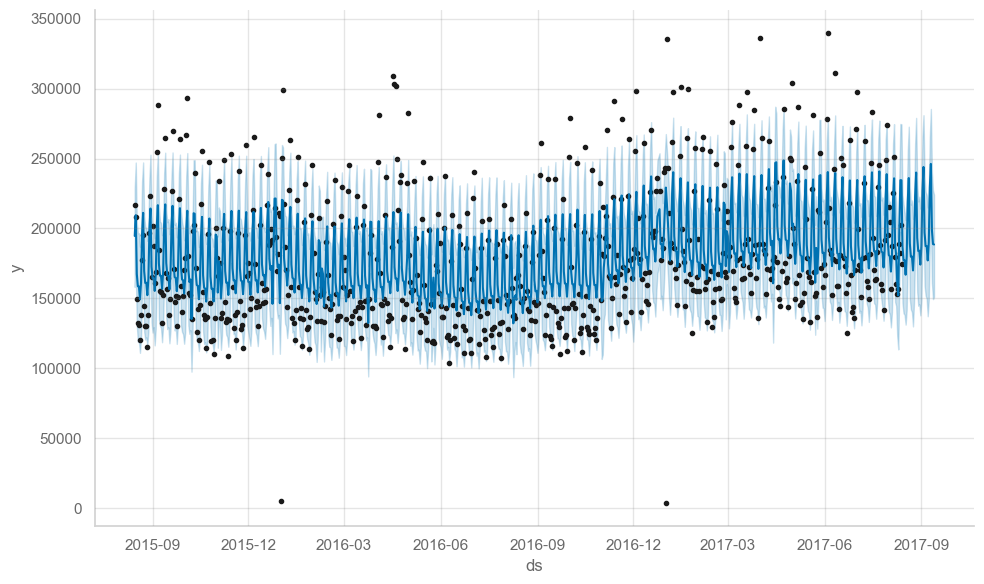

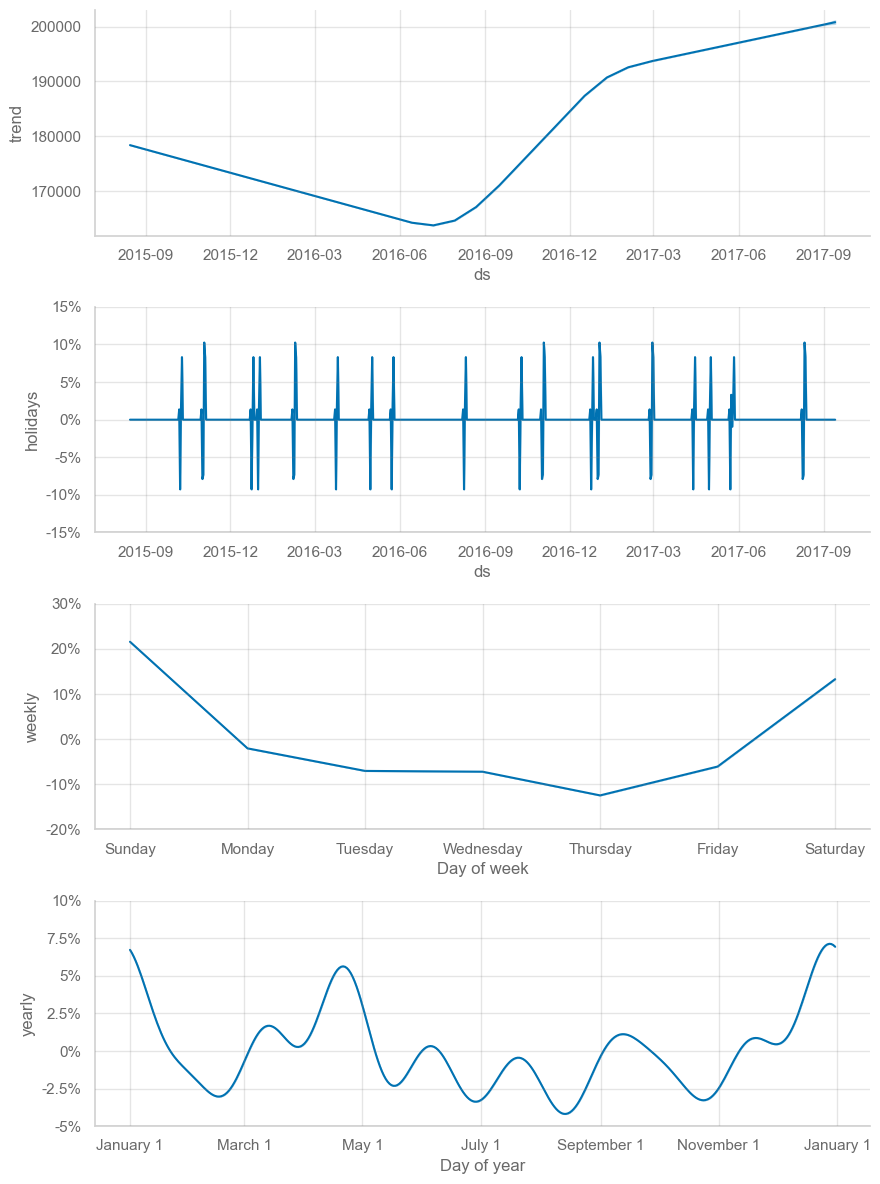

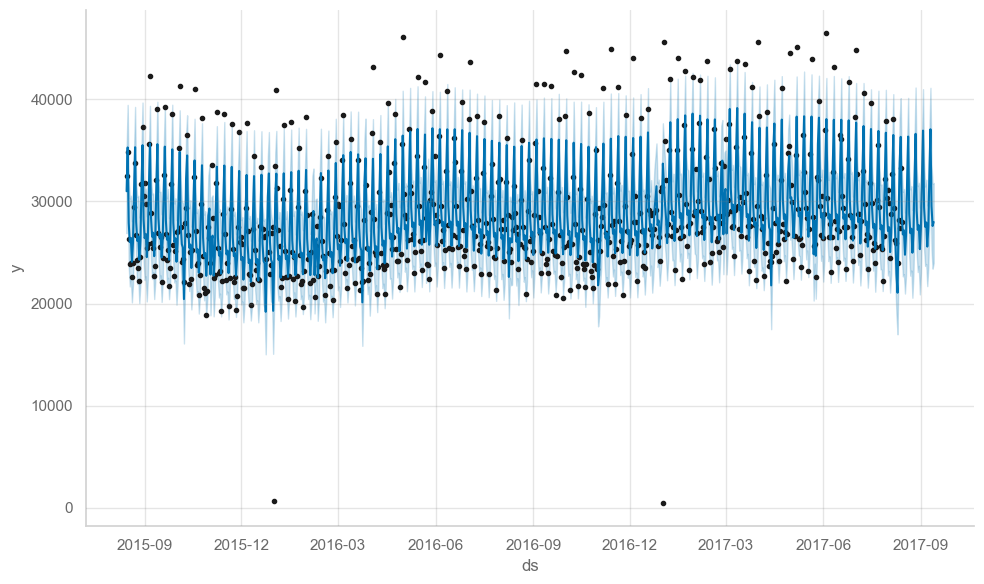

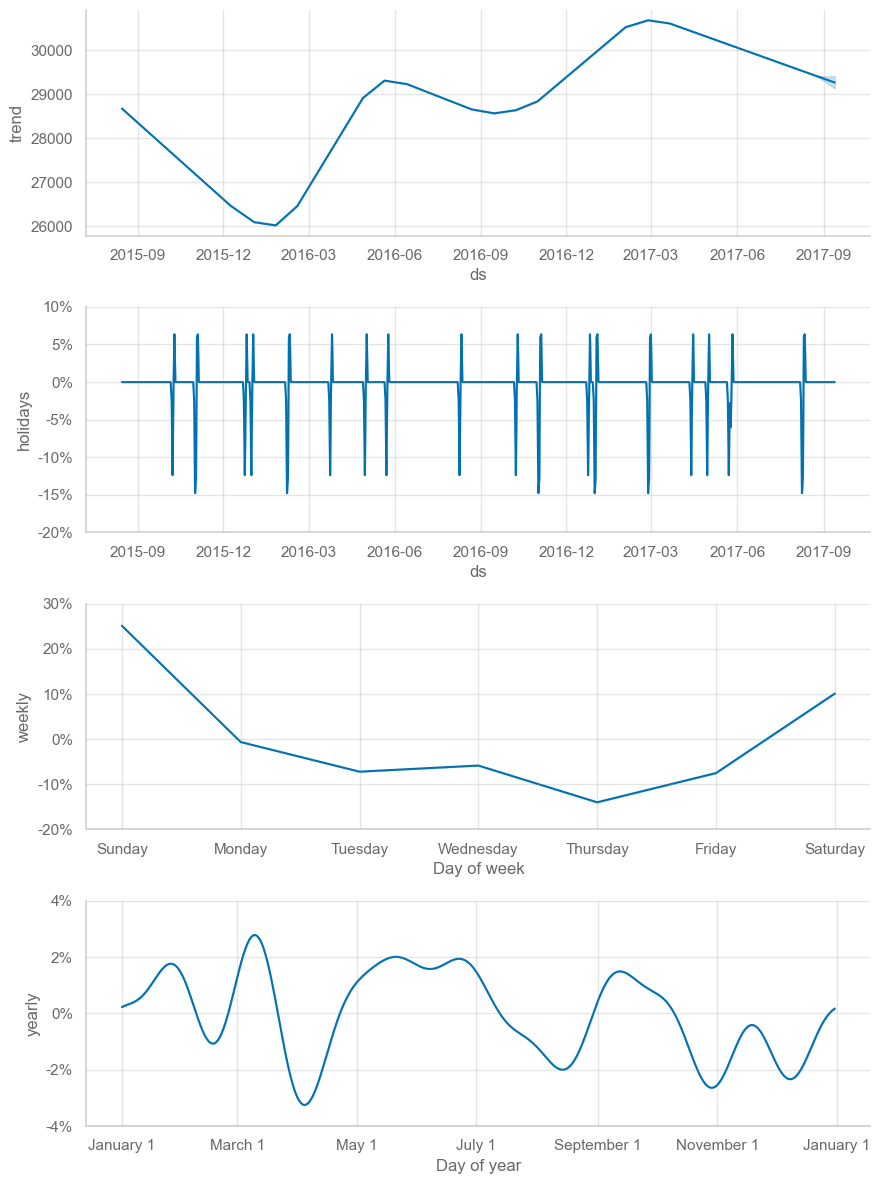

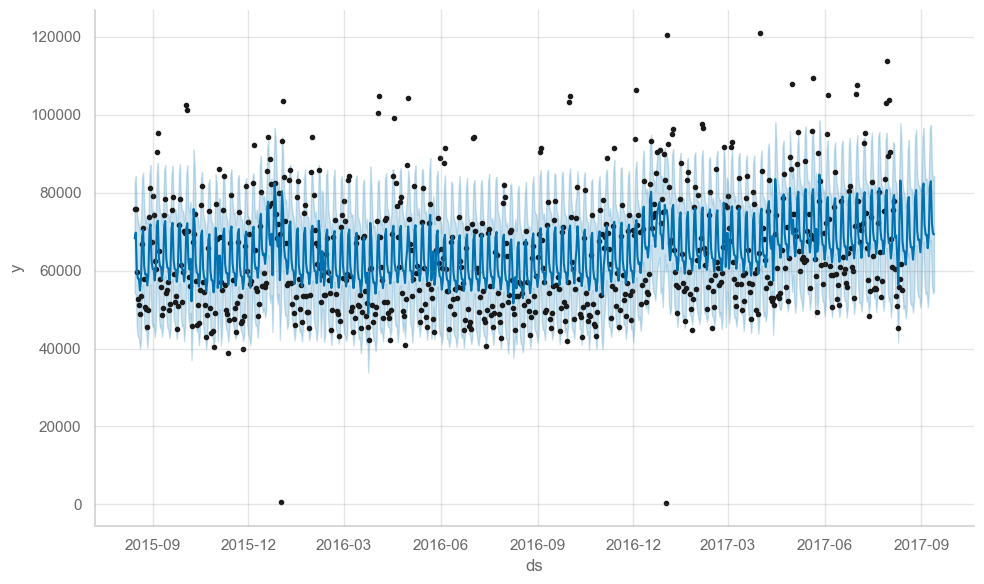

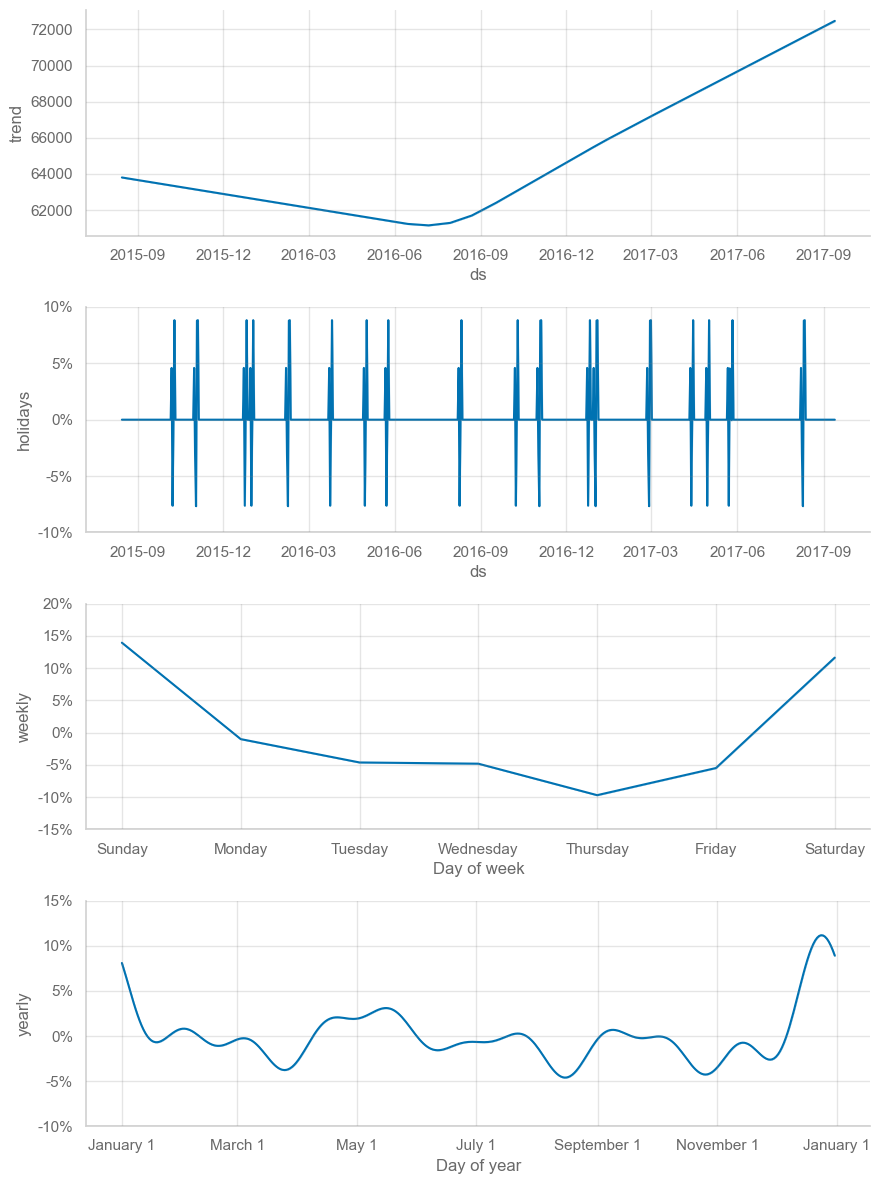

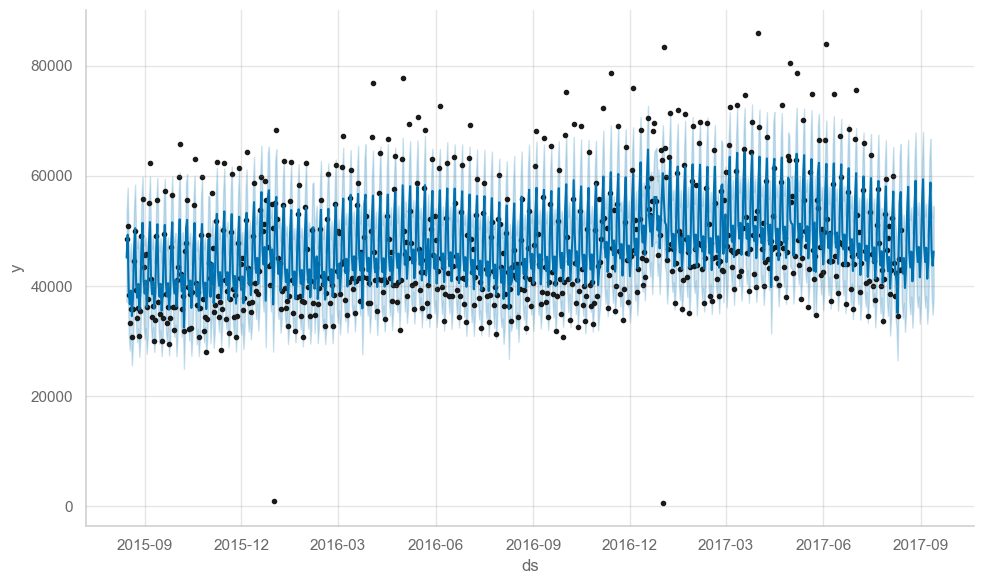

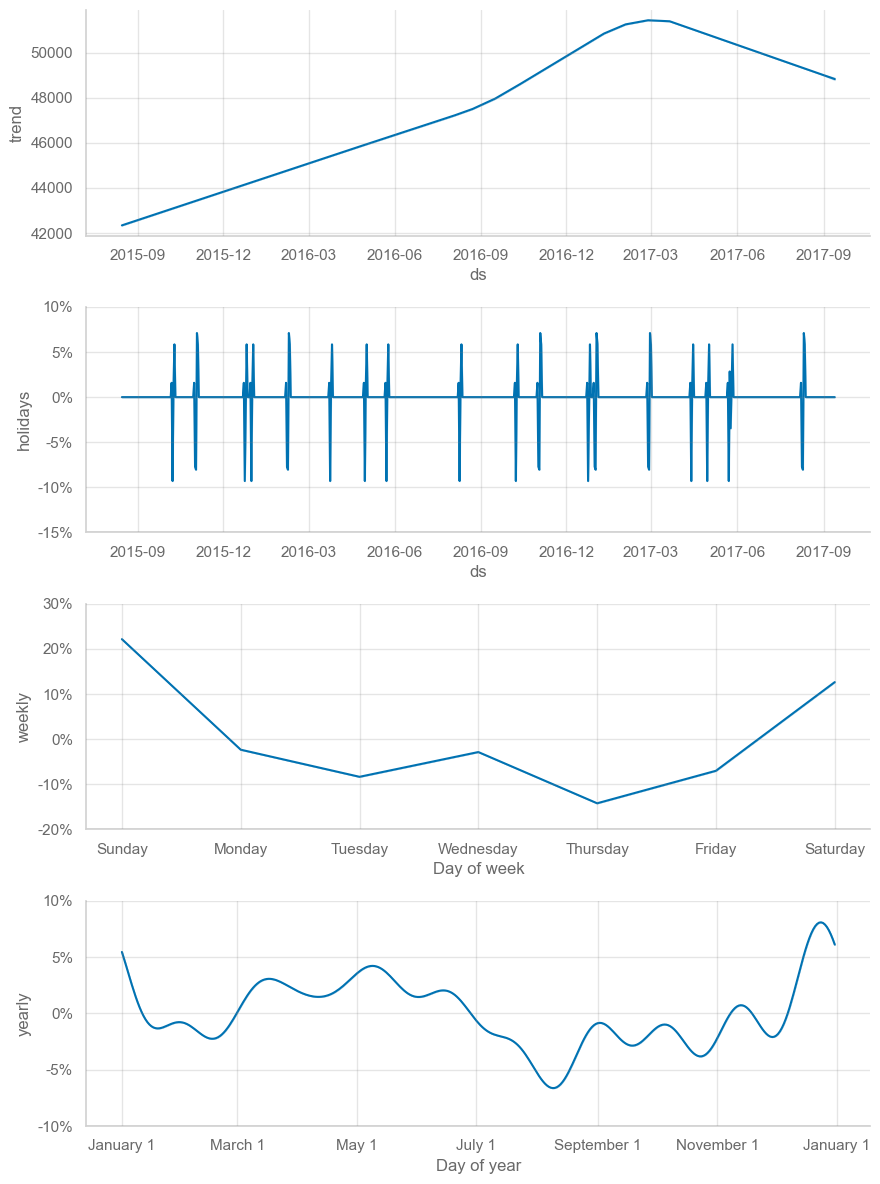

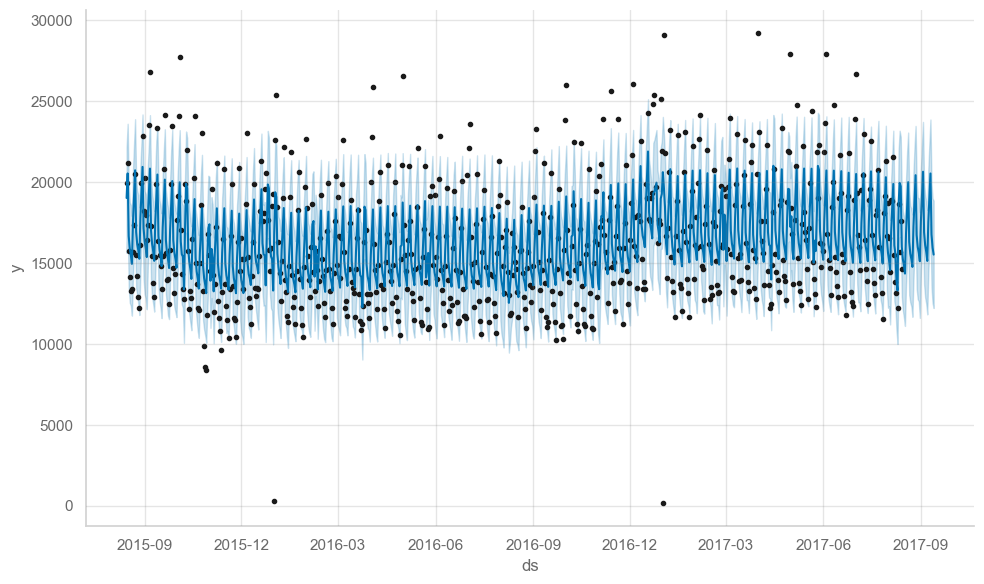

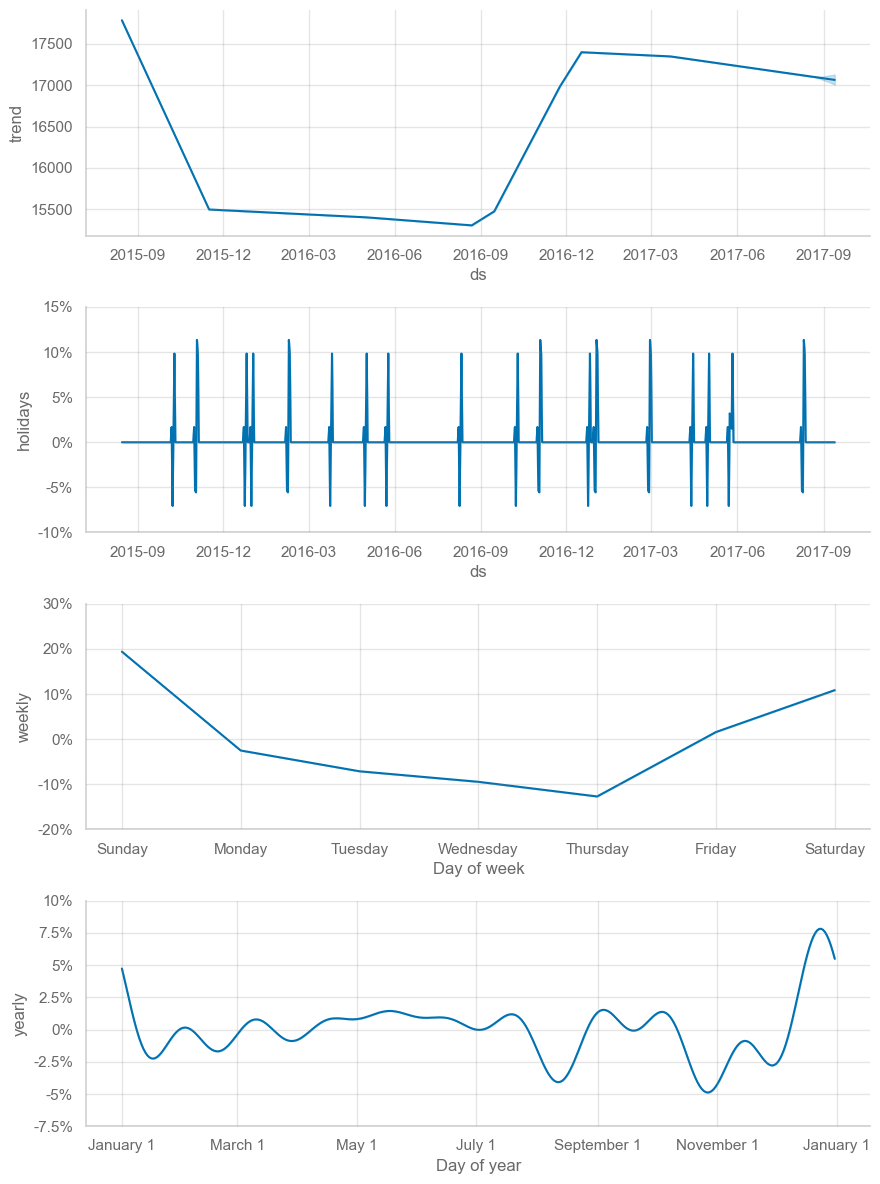

In [ ]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns[:5]:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)

In [ ]:
total_sales_df.columns

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')